### Library 

In [1]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt

sys.path.append('/home/antorosi/Documents/AutoEncoder/')
from load_shape_data import conso_ds_to_array, plot_conso_day
from CVAE.cvae import compile_cvae, run_cvae

/local/home/antorosi/PycharmProjects/KERAS-TS-VENV/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_data_folder = "/local/home/antorosi/Documents/AutoEncoder/data"

### Import data

In [3]:
conso_csv = os.path.join(path_data_folder, "conso_Y.csv")
conso_df = pd.read_csv(conso_csv, sep=";", engine='c', header=0)
conso_df['ds'] = pd.to_datetime(conso_df['date'] + ' ' + conso_df['time'])

In [4]:
# get only national observation
Xinput_ds = conso_df[['ds', 'Consommation NAT t0']].copy()

### Result file

In [66]:
# Dataframe containing the relevant data from training of all models
results = pd.DataFrame(columns=['model_name', 'config','weight_loss',
                               'type_recon',
                               'train_loss', 'train_KL', 'train_recon',
                               'test_loss', 'test_KL', 'test_recon',
                               'epochs',
                               'train_size', 'test_size'])



######  Get input array

In [5]:
X, ds = conso_ds_to_array(Xinput_ds)

###### Get conditional variables 

In [6]:
# month
one_hot_month = pd.get_dummies(ds.dt.month, prefix='month')

# weekday
one_hot_weekday = pd.get_dummies(ds.dt.weekday < 6, prefix = 'weekday')

In [7]:
# Getting the conditional array
cond = pd.concat([one_hot_month, one_hot_weekday], axis=1)
cond = cond.as_matrix()

In [17]:
#cond = one_hot_month.as_matrix()

In [9]:
#cond = np.zeros((cond.shape[0],1))

######  Get train and test

In [8]:
X_train = X[:-365,:] 
cond_train = cond[:-365,:]
X_test = X[-365:,:]
cond_test = cond[-365:,:]

In [9]:
cond_train.sum(axis=0)

array([ 124,  113,  124,  120,  124,  101,   93,   93,   90,   93,   90,
         97,  180, 1082], dtype=uint64)

###### Normalization

In [28]:
Min = X_train.min()
Max = X_train.max()

In [29]:
X_train = (X_train-Min)/(Max-Min)
X_test = (X_test-Min)/(Max-Min)

In [10]:
Mean = X_train.mean()
std = X_train.std()

In [11]:
X_train = (X_train-Mean)/(std)
X_test = (X_test-Mean)/(std)

In [12]:
X_train.shape

(1262, 96)



### Building and Running model

In [28]:
cvae, encoder, decoder = compile_cvae(dim_input=96, dim_cond=cond.shape[1], dim_latent_space=12, optim = 'rmsprop')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 96)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 110)          0           input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 48)           5328        concatenate_3[0][0]              
__________

In [13]:
data = ((X_train, cond_train), (X_test, cond_test))

In [30]:
name = "cvae_conso_test"
path_out = '/home/antorosi/Documents/AutoEncoder/out'

Train on 1262 samples, validate on 365 samples
Epoch 1/200
1262/1262 [==============================] - 0s 221us/step - loss: 46.5130 - KL_loss: 6.6991 - recon_loss: 39.8140 - val_loss: 19.9883 - val_KL_loss: 7.4648 - val_recon_loss: 12.5234
Epoch 2/200
1262/1262 [==============================] - 0s 105us/step - loss: 15.6346 - KL_loss: 5.8597 - recon_loss: 9.7749 - val_loss: 15.4374 - val_KL_loss: 6.1477 - val_recon_loss: 9.2897
Epoch 3/200
1262/1262 [==============================] - 0s 92us/step - loss: 13.0143 - KL_loss: 5.2745 - recon_loss: 7.7398 - val_loss: 13.4722 - val_KL_loss: 5.7867 - val_recon_loss: 7.6855
Epoch 4/200
1262/1262 [==============================] - 0s 87us/step - loss: 11.9176 - KL_loss: 5.1514 - recon_loss: 6.7662 - val_loss: 11.4320 - val_KL_loss: 5.5189 - val_recon_loss: 5.9132
Epoch 5/200
1262/1262 [==============================] - 0s 90us/step - loss: 10.7020 - KL_loss: 4.8112 - recon_loss: 5.8908 - val_loss: 11.9532 - val_KL_loss: 4.7685 - val_recon_lo

1262/1262 [==============================] - 0s 102us/step - loss: 4.2293 - KL_loss: 2.1121 - recon_loss: 2.1172 - val_loss: 4.5793 - val_KL_loss: 2.1411 - val_recon_loss: 2.4382
Epoch 44/200
1262/1262 [==============================] - 0s 110us/step - loss: 4.1520 - KL_loss: 2.0886 - recon_loss: 2.0634 - val_loss: 4.7908 - val_KL_loss: 2.4116 - val_recon_loss: 2.3792
Epoch 45/200
1262/1262 [==============================] - 0s 102us/step - loss: 4.2021 - KL_loss: 2.1136 - recon_loss: 2.0884 - val_loss: 5.0134 - val_KL_loss: 2.3050 - val_recon_loss: 2.7084
Epoch 46/200
1262/1262 [==============================] - 0s 115us/step - loss: 4.1961 - KL_loss: 2.1049 - recon_loss: 2.0912 - val_loss: 5.5467 - val_KL_loss: 2.2650 - val_recon_loss: 3.2816
Epoch 47/200
1262/1262 [==============================] - 0s 100us/step - loss: 4.1310 - KL_loss: 2.0654 - recon_loss: 2.0656 - val_loss: 5.5598 - val_KL_loss: 1.8995 - val_recon_loss: 3.6603
Epoch 48/200
1262/1262 [=============================

Epoch 86/200
1262/1262 [==============================] - 0s 105us/step - loss: 3.7665 - KL_loss: 1.8448 - recon_loss: 1.9217 - val_loss: 4.1974 - val_KL_loss: 1.8421 - val_recon_loss: 2.3554
Epoch 87/200
1262/1262 [==============================] - 0s 105us/step - loss: 3.7572 - KL_loss: 1.8618 - recon_loss: 1.8954 - val_loss: 4.3708 - val_KL_loss: 1.9724 - val_recon_loss: 2.3983
Epoch 88/200
1262/1262 [==============================] - 0s 103us/step - loss: 3.6881 - KL_loss: 1.8172 - recon_loss: 1.8708 - val_loss: 4.0469 - val_KL_loss: 1.8653 - val_recon_loss: 2.1816
Epoch 89/200
1262/1262 [==============================] - 0s 103us/step - loss: 3.7390 - KL_loss: 1.8427 - recon_loss: 1.8963 - val_loss: 4.6293 - val_KL_loss: 2.2093 - val_recon_loss: 2.4201
Epoch 90/200
1262/1262 [==============================] - 0s 100us/step - loss: 3.6901 - KL_loss: 1.8366 - recon_loss: 1.8534 - val_loss: 3.9357 - val_KL_loss: 1.7462 - val_recon_loss: 2.1895
Epoch 91/200
1262/1262 [================

1262/1262 [==============================] - 0s 96us/step - loss: 3.5386 - KL_loss: 1.7369 - recon_loss: 1.8017 - val_loss: 3.8081 - val_KL_loss: 1.8087 - val_recon_loss: 1.9994
Epoch 129/200
1262/1262 [==============================] - 0s 102us/step - loss: 3.4589 - KL_loss: 1.7394 - recon_loss: 1.7196 - val_loss: 5.0257 - val_KL_loss: 2.2249 - val_recon_loss: 2.8008
Epoch 130/200
1262/1262 [==============================] - 0s 97us/step - loss: 3.5149 - KL_loss: 1.7528 - recon_loss: 1.7621 - val_loss: 4.1221 - val_KL_loss: 1.9194 - val_recon_loss: 2.2027
Epoch 131/200
1262/1262 [==============================] - 0s 106us/step - loss: 3.5197 - KL_loss: 1.7784 - recon_loss: 1.7413 - val_loss: 3.7123 - val_KL_loss: 1.7064 - val_recon_loss: 2.0059
Epoch 132/200
1262/1262 [==============================] - 0s 103us/step - loss: 3.4996 - KL_loss: 1.7413 - recon_loss: 1.7583 - val_loss: 4.2726 - val_KL_loss: 1.6817 - val_recon_loss: 2.5910
Epoch 133/200
1262/1262 [==========================

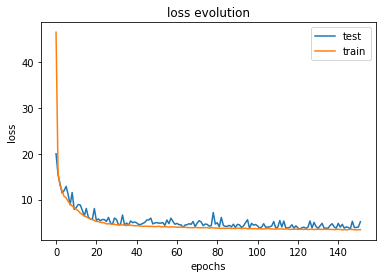

In [31]:
hist = run_cvae(cvae, encoder, decoder, data, batchsize = 15, nb_epochs = 200,name = name, path_out = path_out)

In [ ]:
min_loss = np.min(hist'val_loss'])
            min_idx = np.argmin(hist['val_loss'])
            min_epoch = min_idx + 1

In [ ]:
result = [{'model_name': name, 'config': 0, 'variables': str(selected_var),
                   'train_rmse': model_perf["train"]["rmse"],
                   'train_mae': model_perf["train"]["mae"], 'train_mape': model_perf["train"]["mape"],
                   'test_rmse': model_perf["test"]["rmse"], 'test_mae': model_perf["test"]["mae"],
                   'test_mape': model_perf["test"]["mape"], 'epochs': min_epoch,
                   'nb_inputs': nb_inputs, 'total_time': t.time() - stopper,
                   'dropout': model_config['layers'][0]['dropout'],
                   'cells': model_config['layers'][0]['cells'], 'parameters': model.count_params(),
                   'Train_size': XinputTrain_var.shape[0], 'Test_size': XinputTest1_var.shape[0]
                   }]

In [ ]:
pd.DataFrame(columns=['model_name', 'config','weight_loss',
                               'type_recon',
                               'train_loss', 'train_KL', 'train_recon',
                               'test_loss', 'test_KL', 'test_recon',
                               'epochs',
                               'train_size', 'test_size'])



### Result analysis 

In [32]:
X_hat = cvae.predict([X_train, cond_train])

In [18]:
z_hat = encoder.predict([X_test, cond_test])

z_cond = np.concatenate((z_hat, cond_test),axis=1)

X_hat = decoder.predict(z_cond)

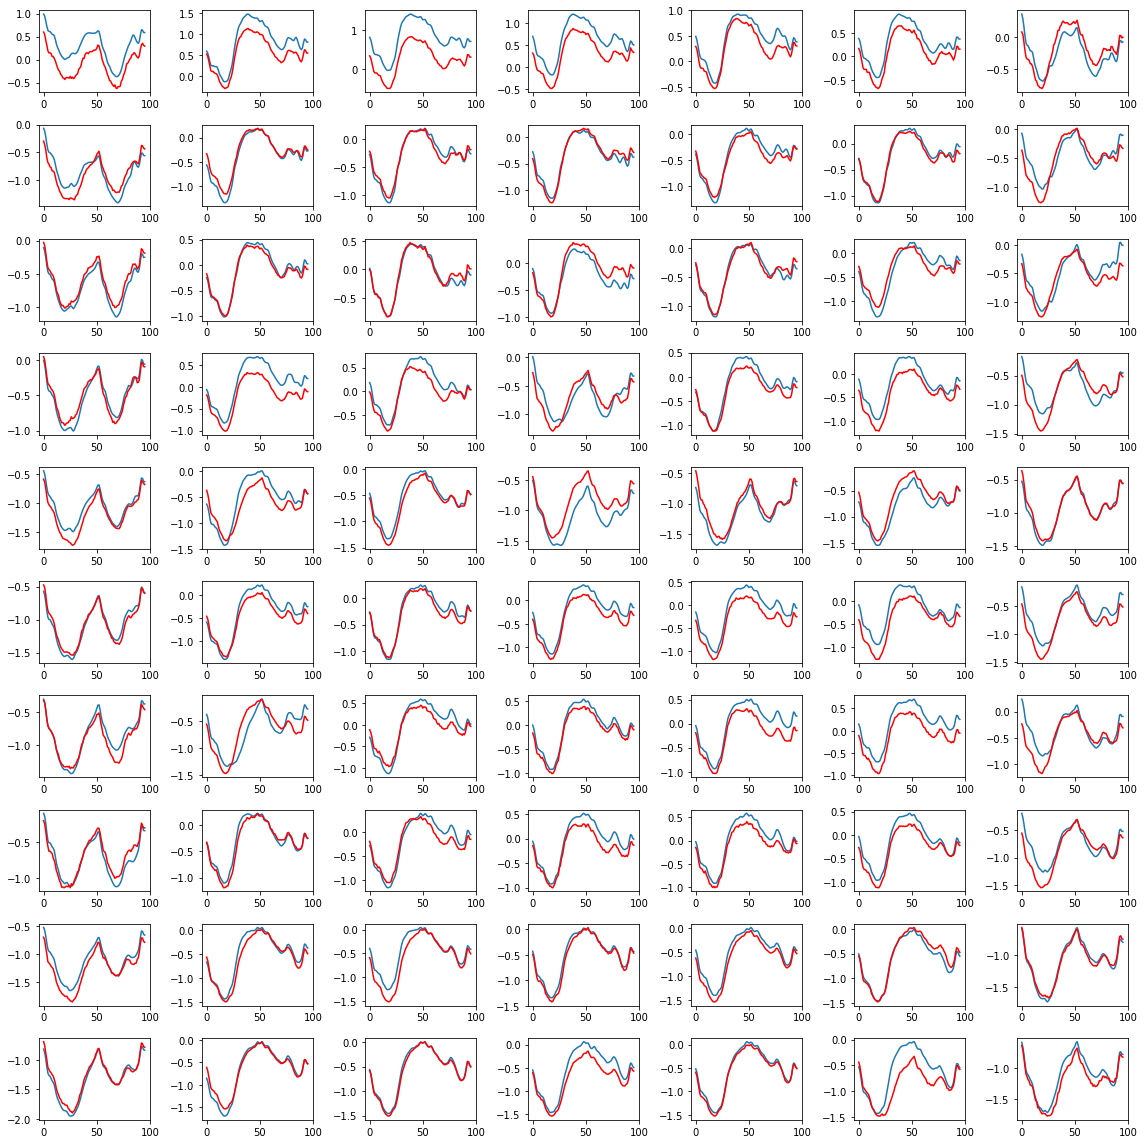

In [33]:
fig, axes = plt.subplots(10,7, figsize=(16,16))

ind = 100

for ax_row in axes:
    for ax in ax_row:
        # create a twin of the axis that shares the x-axis
        # plot some data on each axis.
        ax.plot(X_train[ind,:])
        ax.plot(X_hat[ind,:],'-r')
        
        ind+=1

plt.tight_layout()
plt.show()

In [34]:
residuals = (X_train - X_hat)
residuals_day = residuals.mean(axis=1)

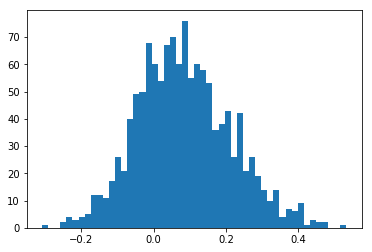

In [35]:
plt.hist(residuals_day, bins=50)
plt.show()

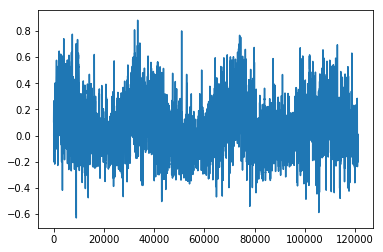

In [37]:
residuals = residuals.reshape(-1,1)
plt.plot(residuals)
plt.show()

In [38]:
month = np.where(cond_train[:,:-2] == 1)[1]

In [54]:
month = np.where(cond_train == 1)[1]

In [59]:
set(month)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

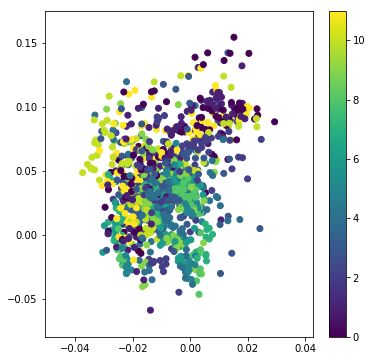

In [39]:
x_test_encoded = encoder.predict([X_train, cond_train])
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c = month )
plt.colorbar()
plt.show()

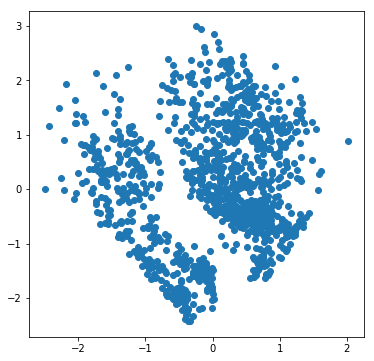

In [111]:
x_test_encoded = encoder.predict([X_train, cond_train])
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1] )
plt.show()

In [48]:
x_test_encoded.shape

(1262, 2)

In [25]:
print(cond_train)

[[0 0 0 ... 1 0 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


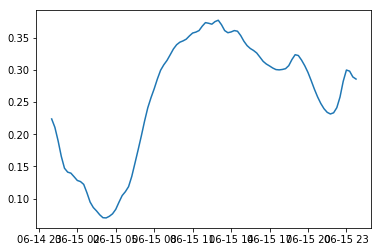

In [59]:
date = datetime.date(2015,6,15)
plot_conso_day(date,X_train,ds)

In [20]:
test = datetime.datetime(2015,3,2)

In [26]:
test1= datetime.date(2015,3,2)

In [14]:
from CVAE.cvae_model import CVAE

In [15]:
model = CVAE(input_dim=96, cond_dim=14, z_dim=2, e_dims = [48,24], d_dims = [24,48])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 96)           0                                            
__________________________________________________________________________________________________
cond (InputLayer)               (None, 14)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 6604        x_true[0][0]                     
                                                                 cond[0][0]                       
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 2)            0           encoder[1][0]                    
          

In [16]:
model.encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_x_true (InputLayer)         (None, 96)           0                                            
__________________________________________________________________________________________________
enc_cond (InputLayer)           (None, 14)           0                                            
__________________________________________________________________________________________________
enc_input (Concatenate)         (None, 110)          0           enc_x_true[0][0]                 
                                                                 enc_cond[0][0]                   
__________________________________________________________________________________________________
enc_dense_0 (Dense)             (None, 48)           5328        enc_input[0][0]                  
__________

In [17]:
model.decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_z (InputLayer)              (None, 2)            0                                            
__________________________________________________________________________________________________
dec_cond (InputLayer)           (None, 14)           0                                            
__________________________________________________________________________________________________
dec_input (Concatenate)         (None, 16)           0           dec_z[0][0]                      
                                                                 dec_cond[0][0]                   
__________________________________________________________________________________________________
dec_dense_0 (Dense)             (None, 24)           408         dec_input[0][0]                  
__________

In [19]:
data = ((X_train, cond_train), (X_test, cond_test))
hist = model.train(data, batch_size=100, training_epochs=100)

Train on 1262 samples, validate on 365 samples
Epoch 1/100
1262/1262 [==============================] - 0s 133us/step - loss: 87.9320 - kl_loss: 1.4493 - recon_loss: 86.4827 - val_loss: 72.9283 - val_kl_loss: 5.8766 - val_recon_loss: 67.0518
Epoch 2/100
1262/1262 [==============================] - 0s 23us/step - loss: 50.9978 - kl_loss: 7.8867 - recon_loss: 43.1112 - val_loss: 38.1930 - val_kl_loss: 10.4562 - val_recon_loss: 27.7368
Epoch 3/100
1262/1262 [==============================] - 0s 25us/step - loss: 28.3136 - kl_loss: 8.7964 - recon_loss: 19.5172 - val_loss: 23.1588 - val_kl_loss: 8.6365 - val_recon_loss: 14.5223
Epoch 4/100
1262/1262 [==============================] - 0s 26us/step - loss: 18.4756 - kl_loss: 6.9948 - recon_loss: 11.4808 - val_loss: 16.6260 - val_kl_loss: 6.8179 - val_recon_loss: 9.8081
Epoch 5/100
1262/1262 [==============================] - 0s 27us/step - loss: 13.7429 - kl_loss: 5.6440 - recon_loss: 8.0989 - val_loss: 12.5678 - val_kl_loss: 5.3080 - val_rec

1262/1262 [==============================] - 0s 28us/step - loss: 5.8513 - kl_loss: 3.3251 - recon_loss: 2.5262 - val_loss: 6.1621 - val_kl_loss: 3.4040 - val_recon_loss: 2.7581
Epoch 44/100
1262/1262 [==============================] - 0s 25us/step - loss: 5.5614 - kl_loss: 3.2458 - recon_loss: 2.3156 - val_loss: 6.4614 - val_kl_loss: 3.5116 - val_recon_loss: 2.9498
Epoch 45/100
1262/1262 [==============================] - 0s 25us/step - loss: 5.4253 - kl_loss: 3.2168 - recon_loss: 2.2085 - val_loss: 7.1031 - val_kl_loss: 3.2355 - val_recon_loss: 3.8676
Epoch 46/100
1262/1262 [==============================] - 0s 28us/step - loss: 5.6745 - kl_loss: 3.2107 - recon_loss: 2.4637 - val_loss: 5.9296 - val_kl_loss: 3.2712 - val_recon_loss: 2.6584
Epoch 47/100
1262/1262 [==============================] - 0s 28us/step - loss: 5.6519 - kl_loss: 3.1849 - recon_loss: 2.4670 - val_loss: 5.9664 - val_kl_loss: 3.1971 - val_recon_loss: 2.7693
Epoch 48/100
1262/1262 [==============================] - 

Epoch 86/100
1262/1262 [==============================] - 0s 24us/step - loss: 4.9223 - kl_loss: 2.8155 - recon_loss: 2.1068 - val_loss: 5.0600 - val_kl_loss: 2.9468 - val_recon_loss: 2.1132
Epoch 87/100
1262/1262 [==============================] - 0s 26us/step - loss: 4.7338 - kl_loss: 2.7775 - recon_loss: 1.9563 - val_loss: 5.5700 - val_kl_loss: 2.9908 - val_recon_loss: 2.5792
Epoch 88/100
1262/1262 [==============================] - 0s 26us/step - loss: 4.8990 - kl_loss: 2.8022 - recon_loss: 2.0968 - val_loss: 5.0795 - val_kl_loss: 2.8830 - val_recon_loss: 2.1965
Epoch 89/100
1262/1262 [==============================] - 0s 27us/step - loss: 4.9077 - kl_loss: 2.7456 - recon_loss: 2.1621 - val_loss: 5.0521 - val_kl_loss: 2.8961 - val_recon_loss: 2.1560
Epoch 90/100
1262/1262 [==============================] - 0s 26us/step - loss: 4.8941 - kl_loss: 2.7749 - recon_loss: 2.1192 - val_loss: 5.0710 - val_kl_loss: 3.0188 - val_recon_loss: 2.0522
Epoch 91/100
1262/1262 [=====================

In [18]:
model.encoder.weights

[<tf.Variable 'enc_dense_0/kernel:0' shape=(110, 48) dtype=float32_ref>,
 <tf.Variable 'enc_dense_0/bias:0' shape=(48,) dtype=float32_ref>,
 <tf.Variable 'enc_dense_1/kernel:0' shape=(48, 24) dtype=float32_ref>,
 <tf.Variable 'enc_dense_1/bias:0' shape=(24,) dtype=float32_ref>,
 <tf.Variable 'latent_dense_mu/kernel:0' shape=(24, 2) dtype=float32_ref>,
 <tf.Variable 'latent_dense_mu/bias:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'latent_dense_log_sigma/kernel:0' shape=(24, 2) dtype=float32_ref>,
 <tf.Variable 'latent_dense_log_sigma/bias:0' shape=(2,) dtype=float32_ref>]

In [21]:
hist.history


{'kl_loss': [1.4493020539616255,
  7.886659431759793,
  8.79644122932301,
  6.994764542617435,
  5.643997942777896,
  4.854110838683018,
  4.465316972717431,
  4.268507612110507,
  4.014973506685671,
  3.9777242869091487,
  3.86949960327753,
  3.7950015974876052,
  3.676451764280558,
  3.679222747376528,
  3.6223815133567845,
  3.6081592730599237,
  3.537222421679368,
  3.5937794320367975,
  3.5915764628801785,
  3.5649284198053666,
  3.490215440937532,
  3.491241653823248,
  3.520804884316615,
  3.4624348767396955,
  3.5326580974832766,
  3.474040865709211,
  3.407311109657711,
  3.3727763976234644,
  3.4549346990328393,
  3.4036431270998366,
  3.337709090600112,
  3.3301623358779397,
  3.3482945626586815,
  3.3578852492542537,
  3.389468867502953,
  3.402479242031623,
  3.3593381078420843,
  3.3212088151892467,
  3.3633986822965594,
  3.290079552095779,
  3.2725703123065446,
  3.297685836272081,
  3.3250942260452003,
  3.2457785016950074,
  3.2167654827166285,
  3.210745144570497,
  

In [32]:
len(hist.history['loss'])

100

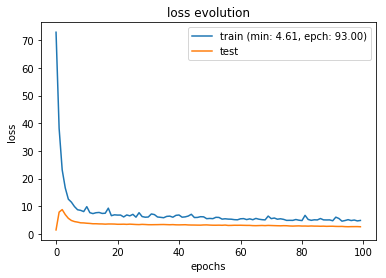

In [44]:
nb_epoch = hist.history['loss']

plt.plot(hist.epoch, hist.history['val_loss'], label='train (min: {:0.2f}, epch: {:0.2f})'.format(min_loss, min_epch))
plt.plot(hist.epoch, hist.history['kl_loss'], label = 'test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss evolution')
plt.legend()

In [41]:
min_epch = np.argmin(hist.history['val_loss'])

In [36]:
hist.history['val_loss'][93]

4.6092496636795675

In [40]:
min_loss = min(hist.history['val_loss'])